In [1]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
fully_agg_df = pd.read_csv('./datasets/100K golferid fully aggregated.csv')

In [3]:
fully_agg_df.head(2)

,golferid,ishomeclub,isvalidplayer,sex,dob,isprofessional,year,approved_rounds,nonapproved_rounds,longest_round,approved_round_ratio,year_from_beginner,the_ith_year2play,average_newhandicap,sd_newhandicap,total_num_rounds,newhandicap_change,oldest_newhandicap,newhandicap_amplitude,scoretype1_ratio,scoretype2_ratio,scoretype3_ratio,scoretype4_ratio,average_nettscore,sd_nettscore,average_score,sd_score,average_par,sd_par,distinct_par,average_scratchrating,sd_scratchrating,par_change_num,newhandicap_change_ratio,newhandicap_change_amp_ratio,isanchored_ratio,isninehole_ratio,css_ratio,lockstatus_ratio,avg_playedto,std_playedto,round_num,is_active,age
0,792168569,True,True,M,1989,False,2015,19,0,18,1.0,34,154425,18.673684,1.093842,19,-2.6,20.8,4.1,0.368,0.526,0.105,0.0,45.705882,27.81808,80.941176,12.832920,68.0,0.0,1,66.789474,0.854982,0,-0.125000,0.634146,0.0,0.0,0.0,0.12,23.531579,4.354443,19,True,26
1,792168569,True,True,M,1989,False,2016,45,0,44,1.0,35,173722,16.606667,0.634035,45,-2.3,18.2,2.7,0.444,0.422,0.133,0.0,46.666667,27.40355,80.000000,11.341797,68.0,0.0,1,67.311111,1.083392,0,-0.126374,0.851852,0.0,0.0,0.0,0.00,20.593333,3.521841,45,True,27


In [4]:
fully_agg_df.shape[0]

238523

# Convert categorical features to numeric

In [5]:
cat_columns = fully_agg_df.select_dtypes(['object']).columns
print(cat_columns)
fully_agg_df['sex'] = fully_agg_df['sex'].apply(lambda x: pd.factorize(x)[0])

Index(['sex'], dtype='object')


# Simple training/test split using stratify parameter

In [6]:
# Exclude the 'golferid' and 'year' columns from the dataset
X = fully_agg_df.loc[:, ~fully_agg_df.columns.isin(['golferid', 'year', 'is_active'])]
y = fully_agg_df.loc[:,'is_active']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
# Cast the y_train set to resolve the unknow error as sklearn cannot recognize its type
y_train = y_train.astype('int')

# Split Train/test datasets

Stratified K-Folds cross-validator. This cross-validation object returns stratified folds made by preserving the percentage of samples for each class to handle the imbalanced dataset.


In [ ]:
# skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
# X = fully_agg_df.loc[:, ~fully_agg_df.columns.isin(['golferid', 'year', 'is_active'])]
# y = fully_agg_df.loc[:,'is_active']

# for train_index, test_index in skf.split(X, y):
#     # Use iloc to select specific rows of the dataFrame based on the integer position
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
# print('Size of X_train is {}'.format(X_train.shape[0]))
# print('Size of X_test is {}'.format(X_test.shape[0]))
# print('Size of y_train is {}'.format(y_train.shape[0]))
# print('Size of y_test is {}'.format(y_test.shape[0]))

# Build Binomial Classifier

In [7]:
def build_binomial_model(X_train, X_test, y_train, y_test):
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)


    clf = LogisticRegression(solver='liblinear', random_state=0)
    clf.fit(X_train_scaled, y_train)

    # Get coefficients to find out feature importance
    importances = pd.DataFrame(data={'Feature': X_train.columns, 'Coefficient': clf.coef_[0]})
    
    #Logistic regression returns coefficients in log odds. Odds ratios need to be converted to probabilities to be more interpretable. 
    # Convert log odds(logit) to probabilities (i.e odds/(1 + odds))
    logit2probs = [np.exp(coefficient)/(1 + np.exp(coefficient)) for coefficient in clf.coef_[0]]
    #print(importances)
    importances = importances.sort_values(by='Coefficient', ascending=False)
    binomial_preds = clf.predict(X_test_scaled)
    binomial_score = clf.score(X_test_scaled, y_test)

    return importances, binomial_preds, binomial_score


In [8]:
# Plot feature importance
def plot_important_features(importances):
    plt.bar(x=importances['Feature'], height=importances['Coefficient'])
    plt.figure(1, figsize=(20, 6))
    # Add labels to the graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important feature obtained from coefficients", size=12)
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


Binomial classifier score is: 0.8888159089956259 



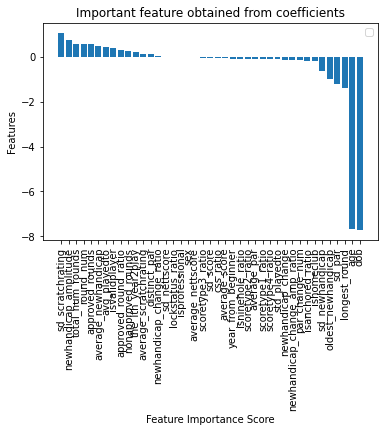

In [9]:
# The score method computes the accuracy score by default (i.e #correct_preds/#all_preds). It makes predictions using X_test 
# under the hood and uses those predictions to calculate accuracy score. The score method does not need the actual predictions.

binomial_importances, binomial_preds, binomial_score = build_binomial_model(X_train, X_test, y_train, y_test)
print('Binomial classifier score is: {} \n'.format(binomial_score))
#print('Accuracy score is: {}'.format(accuracy_score(y_test, binomial_preds)))

plot_important_features(binomial_importances)

If every feature has a similar magnitude, a larger positive/negetive coefficient means larger effect.
https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

# Generating the binomial model on selected features

# Build RandomForest Model

In [10]:
def build_randomforest_classifier(X_train, X_test, y_train):
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


    rf_clf.fit(X_train_scaled, y_train)
    # Get coefficients to find out feature importance
    importances = pd.DataFrame(data={'Feature': X_train.columns, 'Coefficient': rf_clf.feature_importances_})
    importances = importances.sort_values(by='Coefficient', ascending=False)
    rf_preds = rf_clf.predict(X_test_scaled)
    return importances, rf_preds

No handles with labels found to put in legend.


The accuracy of the RandomForest model is 0.9490336375197395 



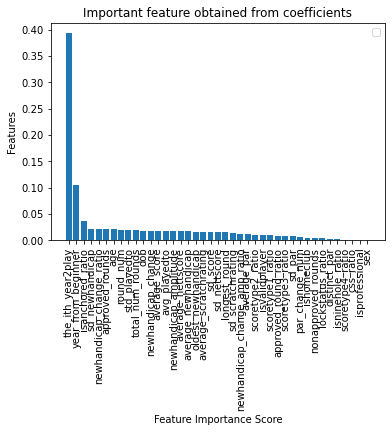

In [11]:
rf_importances, rf_preds = build_randomforest_classifier(X_train, X_test, y_train)
# Model accuracy to check how often the classifier predicts correctly
print("The accuracy of the RandomForest model is {} \n".format(metrics.accuracy_score(y_test, rf_preds)))

plot_important_features(rf_importances)

# Generating the RandomForest model on selected features

# Calculate metrics

In [12]:
def calculate_metrics(true_test_lables, pred_labels):
    true_test_lables = true_test_lables.astype('int')
    # True Positive
    TP = np.sum(np.logical_and(true_test_lables == 1, pred_labels == 1)) / list(true_test_lables).count(1)
    # True Negative
    TN = np.sum(np.logical_and(true_test_lables == 0, pred_labels == 0)) / list(true_test_lables).count(0)
    # False Positive
    FP = np.sum(np.logical_and(true_test_lables == 0, pred_labels == 1)) / list(true_test_lables).count(0)
    # False Negative
    FN = np.sum(np.logical_and(true_test_lables == 1, pred_labels== 0)) / list(true_test_lables).count(1)
    precision = TP/ (TP + FP)
    recall = TP/ (TP + FN)
    return TP, TN, FP, FN, precision, recall


In [13]:
# Calculate fine-grained accuracies for the binomial model
TP, TN, FP, FN,  precision, recall = calculate_metrics(y_test, binomial_preds)
print(' True Positive {} \n True Negative {} \n False Positive {} \n False Negative {} \n Precision {} \n Recall {}'
      .format(TP, TN, FP, FN,  precision, recall))

 True Positive 0.9816095617529881 
 True Negative 0.22765981605541047 
 False Positive 0.7723401839445895 
 False Negative 0.01839043824701195 
 Precision 0.5596566059893491 
 Recall 0.9816095617529881


In [14]:
# Calculate fine-grained accuracies for the RandomForest model
TP, TN, FP, FN,  precision, recall = calculate_metrics(y_test, rf_preds)
print(' True Positive {} \n True Negative {} \n False Positive {} \n False Negative {} \n Precision {} \n Recall {}'
      .format(TP, TN, FP, FN,  precision, recall))

 True Positive 0.9954422310756972 
 True Negative 0.6183717497445214 
 False Positive 0.3816282502554786 
 False Negative 0.004557768924302789 
 Precision 0.7228694860363507 
 Recall 0.9954422310756972


# Balanced Train/Test sets

In [15]:
train_df = pd.read_csv('./datasets/balanced_training_set.csv')
test_df = pd.read_csv('./datasets/balanced_testing_set.csv')

train_df['sex'] = train_df['sex'].apply(lambda x: pd.factorize(x)[0])
test_df['sex'] = test_df['sex'].apply(lambda x: pd.factorize(x)[0])

# Exclude the 'golferid','year', and 'response_prob' columns from the balanced dataset
X_balanced_train = train_df.loc[:, ~train_df.columns.isin(['golferid', 'year', 'is_active'])]
y_balanced_train = train_df.loc[:,'is_active']

X_balanced_test = test_df.loc[:, ~test_df.columns.isin(['golferid', 'year', 'is_active', 'response_prob'])]
y_balanced_test = test_df.loc[:,'is_active']

# Cast the y_train set to resolve the unknow error as sklearn cannot recognize its type
y_balanced_test = y_balanced_test.astype('int')

No handles with labels found to put in legend.


The score of Binomial classifier using the balanced dataset is: 0.7836576761124389 



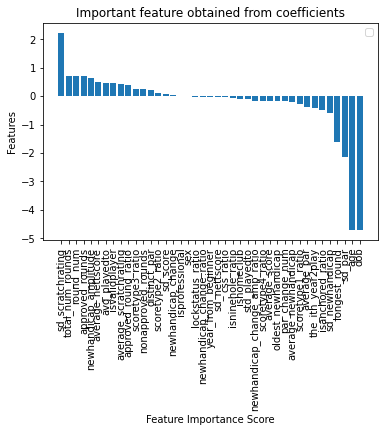

In [16]:
balanced_binomial_importances, balanced_binomial_preds, balanced_binomial_score = build_binomial_model(X_balanced_train, X_balanced_test, 
                                                                                                y_balanced_train, y_balanced_test)

print('The score of Binomial classifier using the balanced dataset is: {} \n'.format(balanced_binomial_score))
#print('Accuracy score is: {}'.format(accuracy_score(y_balanced_test, balanced_binomial_preds)))

# Plot feature importance
plot_important_features(balanced_binomial_importances)

In [17]:
# Calculate accuracies of the balanced dataset using the binomial model
TP, TN, FP, FN,  precision, recall = calculate_metrics(y_balanced_test, balanced_binomial_preds)
print(' True Positive {} \n True Negative {} \n False Positive {} \n False Negative {} \n Precision {} \n Recall {}'
      .format(TP, TN, FP, FN,  precision, recall))

 True Positive 0.7811539774667122 
 True Negative 0.7861613747581655 
 False Positive 0.21383862524183453 
 False Negative 0.2188460225332878 
 Precision 0.7850852110259636 
 Recall 0.7811539774667122


# Check the RandomForest model using the balanced dataset

No handles with labels found to put in legend.


The accuracy of the RandomForest model using the balanced dataset is 0.8790258336178446 



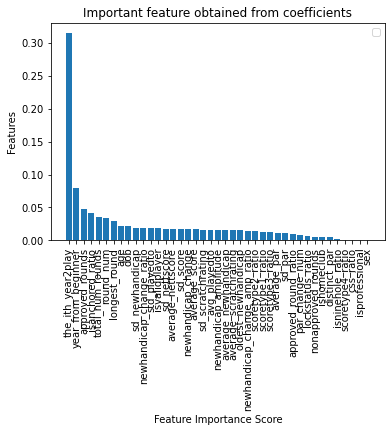

In [18]:
balanced_rf_importances, balanced_rf_preds = build_randomforest_classifier(X_balanced_train, X_balanced_test, y_balanced_train)
# Model accuracy to check how often the classifier predicts correctly
print("The accuracy of the RandomForest model using the balanced dataset is {} \n"
      .format(metrics.accuracy_score(y_balanced_test, balanced_rf_preds)))

plot_important_features(balanced_rf_importances)

In [19]:
# Calculate accuracies of the balanced dataset using the randomforest model
TP, TN, FP, FN,  precision, recall = calculate_metrics(y_balanced_test, balanced_rf_preds)
print(' True Positive {} \n True Negative {} \n False Positive {} \n False Negative {} \n Precision {} \n Recall {}'
      .format(TP, TN, FP, FN,  precision, recall))

 True Positive 0.8970069420735177 
 True Negative 0.8610447251621713 
 False Positive 0.1389552748378286 
 False Negative 0.1029930579264823 
 Precision 0.865868395034604 
 Recall 0.8970069420735177
